In [20]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [21]:
def ConvertToHex(value,bitwidth):
    """
    Converts the value field to 2's compliment hex format
    :param value:  value to convert
    :param bitwidth:   bitwidth of number
    :return:  converted value
    """
    value = int(value)
    if (value > (2**(bitwidth-1) - 1)):
        print('bit conversion failed, too positive')
        return "NULL"
    if (value < -(2**(bitwidth))):
        print('bit conversiion failed, too negative')
        return "NULL"
    # handle negative calculation
    if (value < 0):
        # wrap around to larger positive value, since
        # hex(-100) = -0x64, a not useful response
        value = value + 2**bitwidth;
    value_string = hex(value)
    # now if the value was positive, we want it
    # to take up the correct number of bits
    # chop of the 0x portion
    value_string = value_string[2: ]
    zeros_to_pad = bitwidth // 4 - len(value_string)
    string_out = zeros_to_pad*'0' + value_string
    return string_out


In [27]:
t = np.linspace(0,2*np.pi,1025)
t.size

1025

In [28]:
cos_lut = np.cos(t)
cos_lut = cos_lut[0:1024]

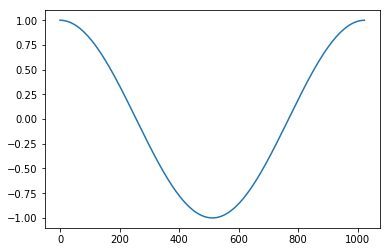

In [29]:
plt.plot(cos_lut)

In [34]:
cos_lut_scale = (2**15-1)*cos_lut

In [35]:
cos_lut_scale_floor = np.floor(cos_lut_scale)
cos_lut_scale_round = np.round(cos_lut_scale)

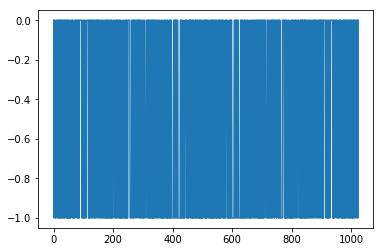

In [36]:
plt.plot(cos_lut_scale_floor  - cos_lut_scale_round)

In [43]:
cos_lut_round_hex = []
cos_lut_floor_hex = []
for x, item in enumerate(cos_lut_scale_floor):
    cos_lut_floor_hex.append(ConvertToHex(item, 16))
    cos_lut_round_hex.append(ConvertToHex(cos_lut_scale_round[x], 16))

In [45]:
cos_lut_floor_hex[1]

'7ffe'

In [46]:
f1 = open('cos_floor.dat', 'w')
f2 = open('cos_round.dat', 'w')
for floored, rounded in zip(cos_lut_floor_hex, cos_lut_round_hex):
    f1.write(f'{floored}\n')
    f2.write(f'{rounded}\n')
f1.close()
f2.close()


In [47]:
cos_lut_round_hex[0]

'7fff'

In [48]:
cos_lut_round_hex[768]

'0000'

In [49]:
cos_lut_floor_hex[768]

'ffff'